In [2]:
#@title All Setup

# Fetch Data
import os, requests
fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"
if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

# Matplotlib Settings
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Load Data
import numpy as np
from sklearn import linear_model
from scipy.stats import zscore
from sklearn.decomposition import PCA
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

svdtime = dat['beh_svd_time']
svdmask = dat['beh_svd_mask']

sresp = dat['sresp']


dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


# Motion Energy

In [3]:
#@title Extract Motion Energy (slow + eats mem)
recon = svdmask @ svdtime.T
abs_motion_energy = np.sum(recon, axis=(0,1)) / (240 * 320)

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components = 200).fit_transform(Z.T)

y = abs_motion_energy

In [76]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import ShuffleSplit

regr = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.3)

rows, cols = X.shape
overall = np.zeros((10,10))

for before in range(9):
  for after in range(9):

    repeats = before + after
    newrows = rows - repeats
    newcols = cols * (repeats + 1)

    Xtest = np.zeros((newrows, newcols))
    for i in range(repeats + 1):
      Xtest[:,i*cols:(i+1)*cols] = X[i:newrows+i,:]

    ytest = y[before:rows - after]

    overall[before,after] = np.mean(cross_val_score(regr, Xtest, ytest, cv=cv))
    print('finished {} before and {} after'.format(before, after))

finished 0 before and 0 after
finished 0 before and 1 after
finished 0 before and 2 after
finished 0 before and 3 after
finished 0 before and 4 after
finished 0 before and 5 after
finished 0 before and 6 after
finished 0 before and 7 after
finished 0 before and 8 after
finished 1 before and 0 after
finished 1 before and 1 after
finished 1 before and 2 after
finished 1 before and 3 after
finished 1 before and 4 after
finished 1 before and 5 after
finished 1 before and 6 after
finished 1 before and 7 after
finished 1 before and 8 after
finished 2 before and 0 after
finished 2 before and 1 after
finished 2 before and 2 after
finished 2 before and 3 after
finished 2 before and 4 after
finished 2 before and 5 after
finished 2 before and 6 after
finished 2 before and 7 after
finished 2 before and 8 after
finished 3 before and 0 after
finished 3 before and 1 after
finished 3 before and 2 after
finished 3 before and 3 after
finished 3 before and 4 after
finished 3 before and 5 after
finished 3

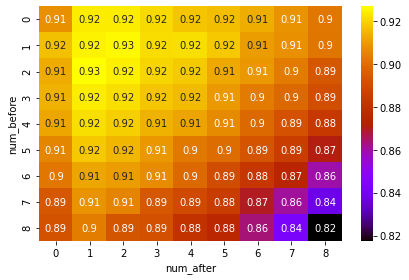

In [82]:
import seaborn as sns
sns.heatmap(overall[0:9,0:9], annot=True, cmap='gnuplot')
plt.ylabel('num_before')
plt.xlabel('num_after')
plt.show()

In [ ]:
np.sum(recon)

165182959.4533592

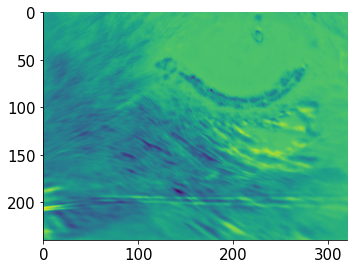

In [ ]:
plt.imshow(recon[:,:,100])

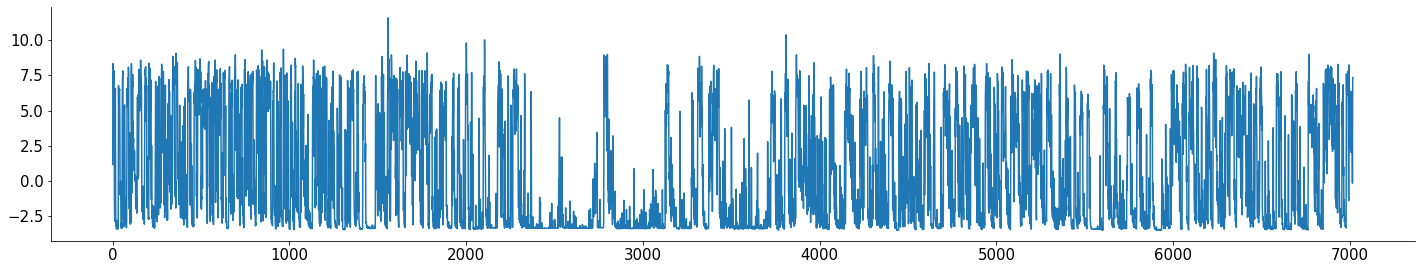

In [ ]:
plt.plot(abs_motion_energy)

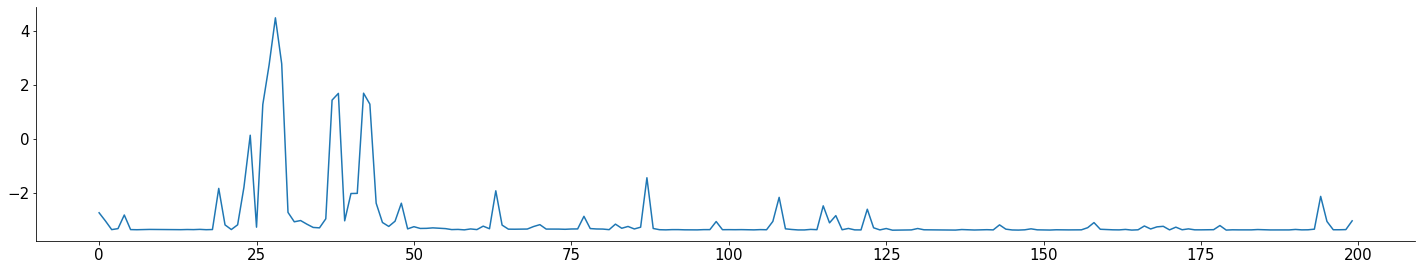

In [ ]:
plt.plot(abs_motion_energy[2500:2700])

In [ ]:
recon[:,:,1090]

array([[-1.56654390e-01,  4.28679321e-01,  1.32649758e+00, ...,
        -3.13514388e-01, -4.37376363e-01, -2.13139026e-01],
       [ 8.69560571e-01,  1.49617343e+00,  6.37750190e-01, ...,
        -1.11302732e-03, -1.02979279e-01, -3.34138943e-01],
       [ 1.48186476e+00,  5.57064262e-01, -1.69764303e+00, ...,
         1.91866217e-01, -2.06250099e-01, -1.25173376e-01],
       ...,
       [ 5.55784671e+00,  5.10457984e+00,  4.87687940e+00, ...,
        -3.08636803e-02, -1.35838423e-01, -3.93583021e-01],
       [ 6.00420456e+00,  5.29547771e+00,  4.73104165e+00, ...,
         1.48832512e-01,  5.17752438e-03,  2.17508442e-01],
       [ 6.08651869e+00,  6.25122255e+00,  5.70540104e+00, ...,
         5.74656712e-02,  2.56675199e-01,  7.81968146e-01]])

In [1]:
for frame in range(1000, 1020):
  plt.imshow(recon[:,:,frame])
  print(abs_motion_energy[frame])
  plt.show()


NameError: ignored

In [ ]:
#@title PCA
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components = 200).fit_transform(Z.T)

y = abs_motion_energy

0.9137364150049889


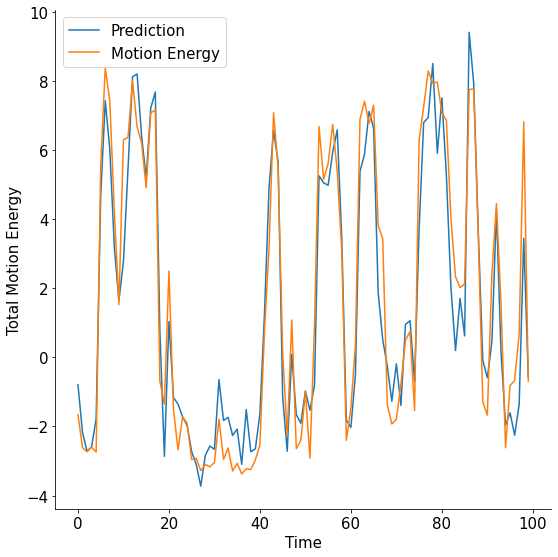

In [ ]:
#@title Multiple Linear Regression
regr = linear_model.LinearRegression()
regr.fit(X, y)

p1 = regr.predict(X)
†
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
plt.plot(p1[200:300], label='Prediction')
plt.plot(y[200:300], label='Motion Energy')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Total Motion Energy')

print(regr.score(X,y))

0.9137364141837666


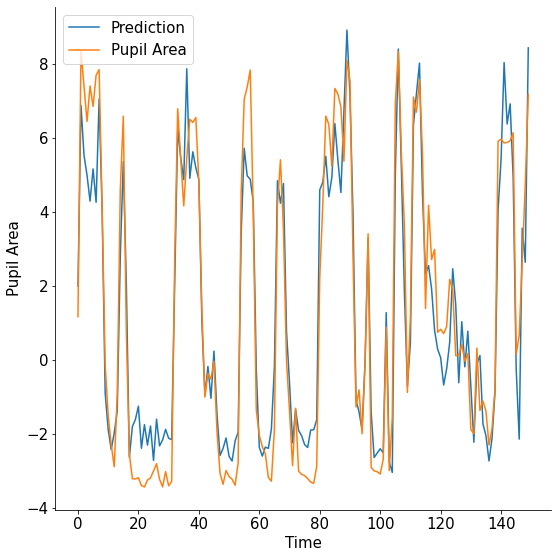

In [ ]:
#@title Ridge Regression
regr = linear_model.Ridge(alpha=1.0)
regr.fit(X, y)

p1 = regr.predict(X)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
plt.plot(p1[:150], label='Prediction')
plt.plot(y[:150], label='Pupil Area')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Pupil Area')

print(regr.score(X,y))

0.7869070752719824


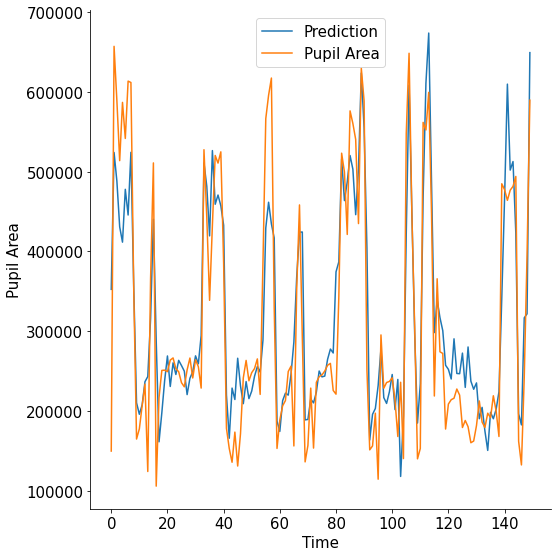

In [ ]:
#@title Lasso
regr = linear_model.Lasso(alpha=1.0)
regr.fit(X, y)

p1 = regr.predict(X)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
plt.plot(p1[:150], label='Prediction')
plt.plot(y[:150], label='Pupil Area')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Pupil Area')

print(regr.score(X,y))



# GLM PupilArea


dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (14752 by 8118). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [50]:
#@title PCA

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components = 200).fit_transform(Z.T)

y = dat['pupilArea']

In [58]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import ShuffleSplit

regr = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.3)

rows, cols = X.shape
overall = np.zeros((10,10))

for before in range(9):
  for after in range(9):

    repeats = before + after
    newrows = rows - repeats
    newcols = cols * (repeats + 1)

    X_alt = np.zeros((newrows, newcols))
    for i in range(repeats + 1):
      X_alt[:,i*cols:(i+1)*cols] = X[i:newrows+i,:]

    y_alt = y[before:rows - after]

    overall[before,after] = np.mean(cross_val_score(regr, X_alt, y_alt, cv=cv))
    print('finished {} before and {} after'.format(before, after))


finished 0 before and 0 after
finished 0 before and 1 after
finished 0 before and 2 after
finished 0 before and 3 after
finished 0 before and 4 after
finished 0 before and 5 after
finished 0 before and 6 after
finished 0 before and 7 after
finished 0 before and 8 after
finished 1 before and 0 after
finished 1 before and 1 after
finished 1 before and 2 after
finished 1 before and 3 after
finished 1 before and 4 after
finished 1 before and 5 after
finished 1 before and 6 after
finished 1 before and 7 after
finished 1 before and 8 after
finished 2 before and 0 after
finished 2 before and 1 after
finished 2 before and 2 after
finished 2 before and 3 after
finished 2 before and 4 after
finished 2 before and 5 after
finished 2 before and 6 after
finished 2 before and 7 after
finished 2 before and 8 after
finished 3 before and 0 after
finished 3 before and 1 after
finished 3 before and 2 after
finished 3 before and 3 after
finished 3 before and 4 after
finished 3 before and 5 after
finished 3

In [59]:
ofile = 'regression_windows'
np.save(ofile, overall)

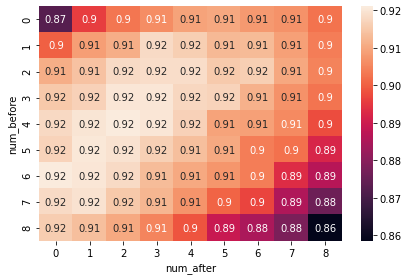

In [63]:
import seaborn as sns
sns.heatmap(overall[0:9,0:9], annot=True)
plt.ylabel('num_before')
plt.xlabel('num_after')
plt.show()

0.8846725266953727


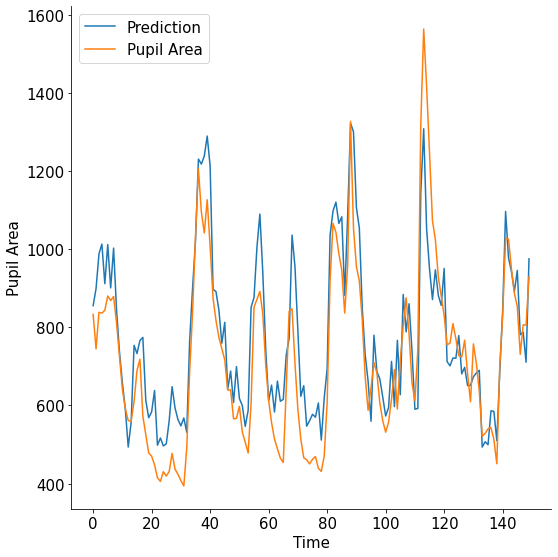

In [ ]:
#@title Multiple Linear Regression
regr = linear_model.LinearRegression()
regr.fit(X, y)

p1 = regr.predict(X)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
plt.plot(p1[:150], label='Prediction')
plt.plot(y[:150], label='Pupil Area')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Pupil Area')

print(regr.score(X,y))

0.8846725282352834


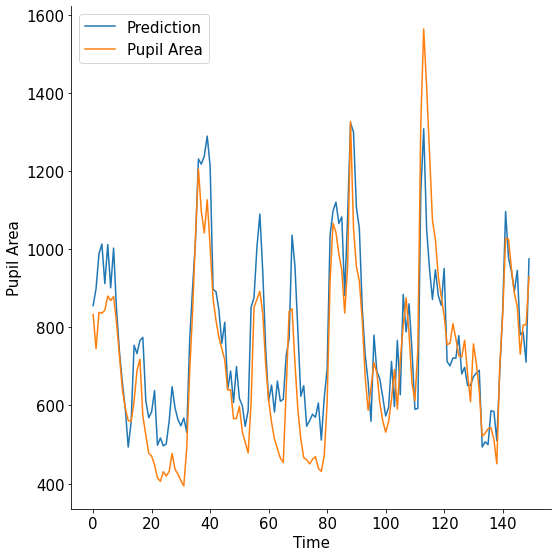

In [ ]:
#@title Ridge Regression
regr = linear_model.Ridge(alpha=1.0)
regr.fit(X, y)

p1 = regr.predict(X)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
plt.plot(p1[:150], label='Prediction')
plt.plot(y[:150], label='Pupil Area')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Pupil Area')

print(regr.score(X,y))

0.8844810950098422


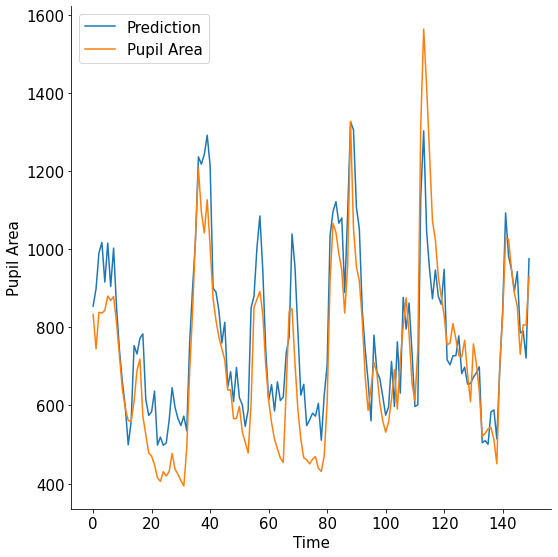

In [ ]:
#@title Lasso
regr = linear_model.Lasso(alpha=1.0)
regr.fit(X, y)

p1 = regr.predict(X)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
plt.plot(p1[:150], label='Prediction')
plt.plot(y[:150], label='Pupil Area')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Pupil Area')

print(regr.score(X,y))

# GLM Running

In [84]:
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components = 200).fit_transform(Z.T)

running_threshold = np.mean(dat['run'])
labels = [0 if val < running_threshold else 1 for val in dat['run']]
y = [0 if sum(labels[i:i+3]) == 0 else 1 for i, val in enumerate(labels)]

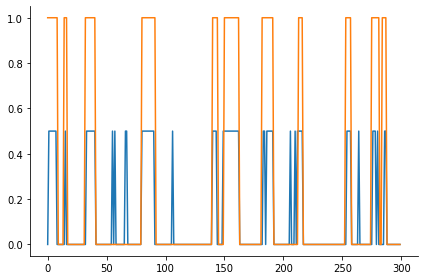

In [87]:
regr = linear_model.LogisticRegression()
# cv = ShuffleSplit(n_splits=5, test_size=0.3)
regr.fit(X,y)
pred = regr.predict(X)

plt.plot(pred[:300]*0.5)
plt.plot(y[:300])


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing

regr = linear_model.LogisticRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.3)

rows, cols = X.shape
overall = np.zeros((10,10))

for before in range(9):
  for after in range(9):

    repeats = before + after
    newrows = rows - repeats
    newcols = cols * (repeats + 1)

    Xtest = np.zeros((newrows, newcols))
    for i in range(repeats + 1):
      Xtest[:,i*cols:(i+1)*cols] = X[i:newrows+i,:]

    Xtest = preprocessing.scale(Xtest)
    ytest = y[before:rows - after]

    overall[before,after] = np.mean(cross_val_score(regr, Xtest, ytest, cv=cv))
    print('finished {} before and {} after'.format(before, after))



finished 0 before and 0 after
finished 0 before and 1 after
finished 0 before and 2 after
finished 0 before and 3 after
finished 0 before and 4 after
finished 0 before and 5 after
finished 0 before and 6 after
finished 0 before and 7 after
finished 0 before and 8 after
finished 1 before and 0 after
finished 1 before and 1 after
finished 1 before and 2 after
finished 1 before and 3 after
finished 1 before and 4 after
finished 1 before and 5 after
finished 1 before and 6 after
finished 1 before and 7 after
finished 1 before and 8 after
finished 2 before and 0 after


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


finished 2 before and 1 after
finished 2 before and 2 after
finished 2 before and 3 after
finished 2 before and 4 after
finished 2 before and 5 after
finished 2 before and 6 after
finished 2 before and 7 after
finished 2 before and 8 after


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


finished 3 before and 0 after
finished 3 before and 1 after
finished 3 before and 2 after
finished 3 before and 3 after
finished 3 before and 4 after
finished 3 before and 5 after
finished 3 before and 6 after
finished 3 before and 7 after
finished 3 before and 8 after


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


finished 4 before and 0 after
finished 4 before and 1 after
finished 4 before and 2 after
finished 4 before and 3 after
finished 4 before and 4 after
finished 4 before and 5 after
finished 4 before and 6 after
finished 4 before and 7 after
finished 4 before and 8 after


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


finished 5 before and 0 after
finished 5 before and 1 after
finished 5 before and 2 after
finished 5 before and 3 after
finished 5 before and 4 after
finished 5 before and 5 after
finished 5 before and 6 after
finished 5 before and 7 after
finished 5 before and 8 after


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


finished 6 before and 0 after
finished 6 before and 1 after
finished 6 before and 2 after
finished 6 before and 3 after
finished 6 before and 4 after
finished 6 before and 5 after
finished 6 before and 6 after
finished 6 before and 7 after
finished 6 before and 8 after
finished 7 before and 0 after
finished 7 before and 1 after
finished 7 before and 2 after
finished 7 before and 3 after
finished 7 before and 4 after
finished 7 before and 5 after
finished 7 before and 6 after
finished 7 before and 7 after
finished 7 before and 8 after
finished 8 before and 0 after
finished 8 before and 1 after
finished 8 before and 2 after
finished 8 before and 3 after
finished 8 before and 4 after
finished 8 before and 5 after
finished 8 before and 6 after
finished 8 before and 7 after
finished 8 before and 8 after


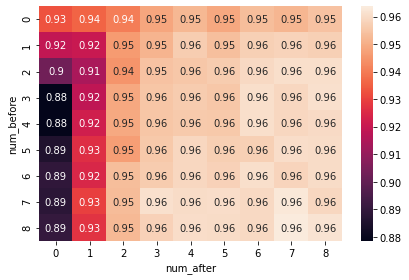

In [74]:
import seaborn as sns
sns.heatmap(overall[0:9,0:9], annot=True)
plt.ylabel('num_before')
plt.xlabel('num_after')
plt.show()

# Misc

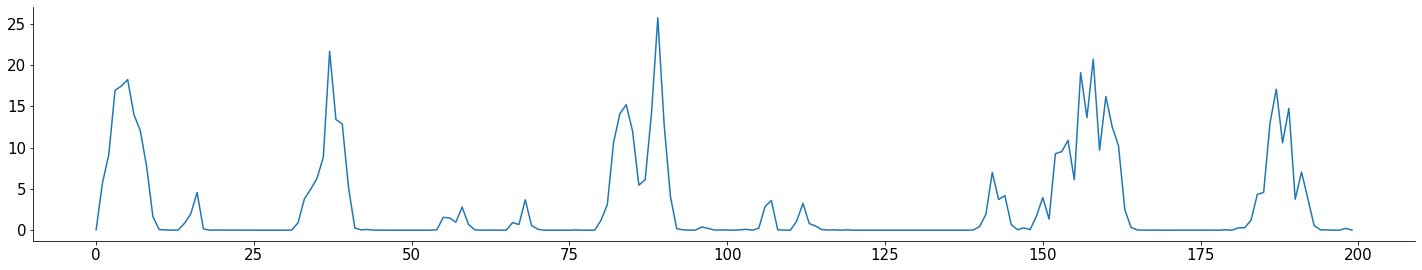

In [ ]:
plt.plot(dat['run'][:200])

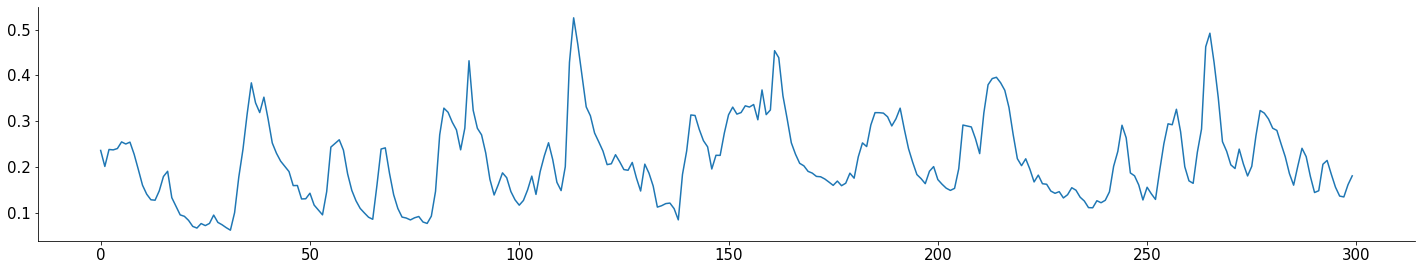

In [ ]:
# plt.plot(dat['pupilArea'][:300])
newdat = (dat['pupilArea'] - np.min(dat['pupilArea'])) / np.max(dat['pupilArea'])
plt.plot(newdat[:300])


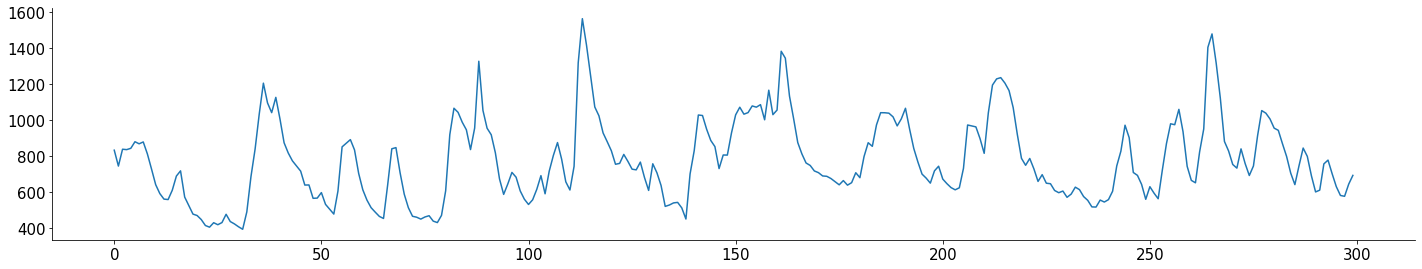

In [ ]:
plt.plot(dat['pupilArea'][:300])

In [ ]:
print(dat['pupilArea'].shape)
print(dat['beh_svd_time'].shape)

(7018, 1)
(7018, 1000)


In [ ]:
print(dat.keys())


dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


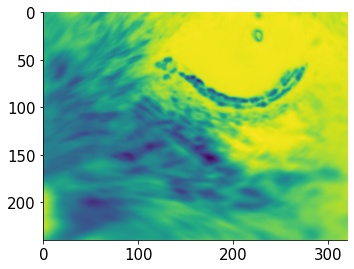

In [ ]:
plt.imshow(dat['beh_svd_mask'][:,:,0])

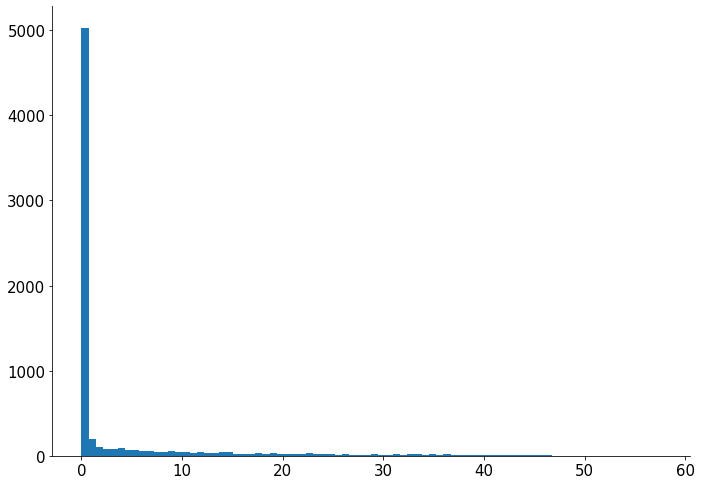

In [ ]:
fig = plt.figure(figsize=(10,7))
_ = plt.hist(dat['run'], bins=80)

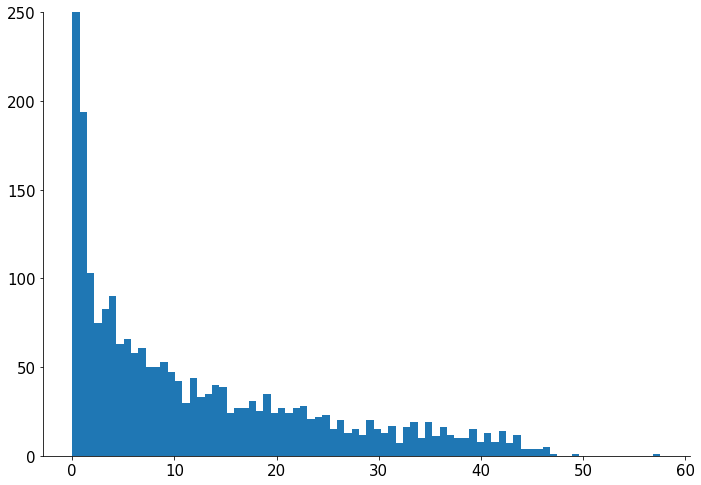

In [ ]:
fig = plt.figure(figsize=(10,7))
plt.ylim(top=250)
_ = plt.hist(dat['run'], bins=80)


(7018, 1000)

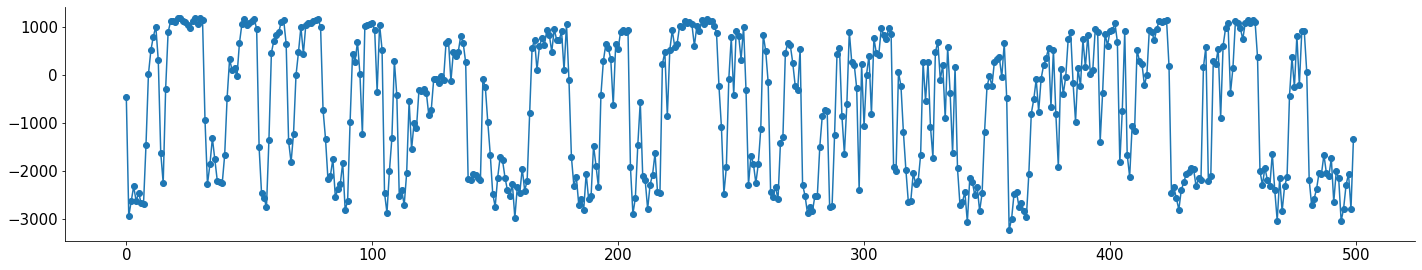

In [ ]:
plt.plot(dat['beh_svd_time'][:500,0], 'o-')
dat['beh_svd_time'].shape

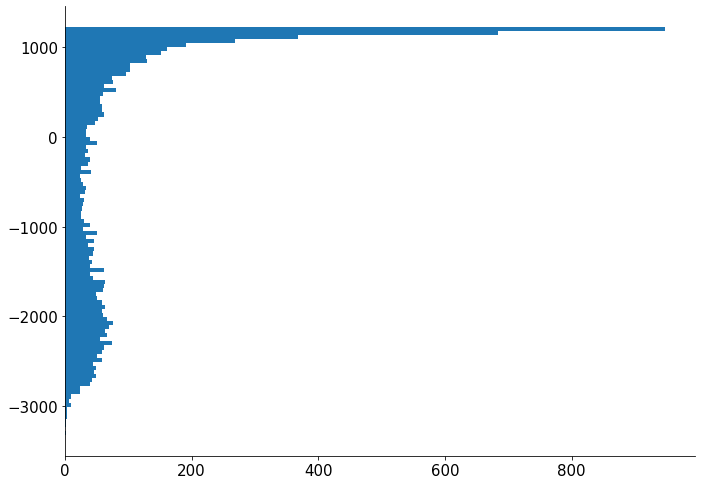

In [ ]:
fig = plt.figure(figsize=(10,7))
_ = plt.hist(dat['beh_svd_time'][:7018,0], bins=100, orientation='horizontal')


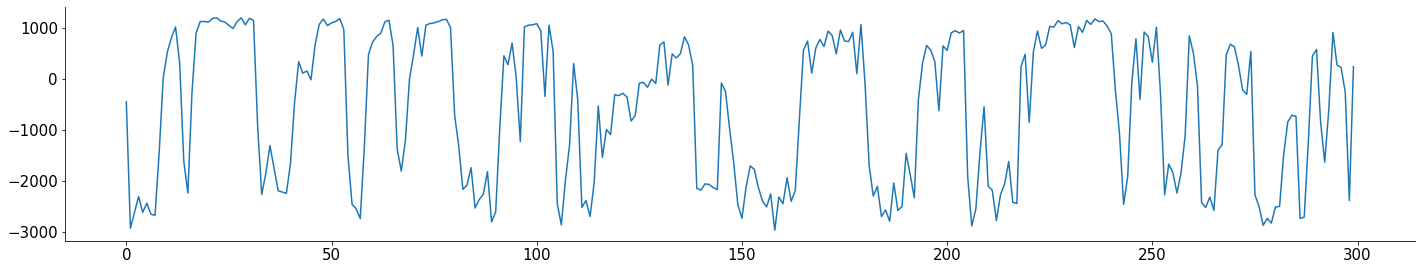

In [ ]:
plt.plot(dat['beh_svd_time'][:300,0])

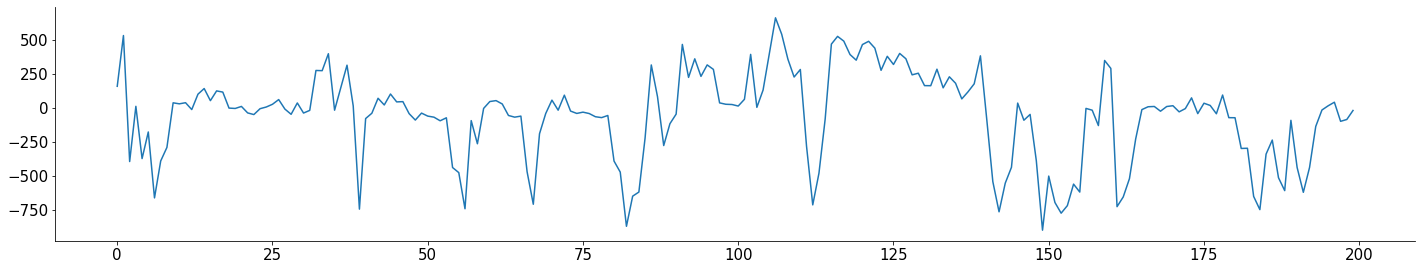

In [ ]:
plt.plot(dat['beh_svd_time'][:200,1])

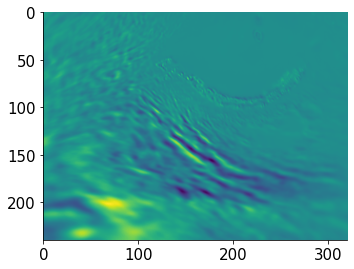

In [ ]:
plt.imshow(dat['beh_svd_mask'][:,:,5])

In [ ]:
#@title Animation line
fig, ax = plt.subplots()
plt.close()
fig.set_size_inches(10, 10)


ax.set_xlim((-3200, 1500))
ax.set_ylim((-900, 750))

x = []
y = []

mat, = ax.plot(x, y, 'o-', lw=2)

# animation function. This is called sequentially  
def animate(i):
    x.append(dat['beh_svd_time'][i,0])
    y.append(dat['beh_svd_time'][i,1])
    mat.set_data(x, y)
    return (mat,)
  

anim = animation.FuncAnimation(fig, animate, frames=200,
                              interval=100, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Animation dot
fig, ax = plt.subplots()
plt.close()
fig.set_size_inches(10, 10)


ax.set_xlim((-3200, 1500))
ax.set_ylim((-900, 750))

x = []
y = []

mat, = ax.plot(x, y, 'o', lw=2)

# animation function. This is called sequentially  
def animate(i):
    x.append(dat['beh_svd_time'][i,0])
    y.append(dat['beh_svd_time'][i,1])
    mat.set_data(x, y)
    return (mat,)
  

anim = animation.FuncAnimation(fig, animate,
                              interval=100, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title movie recon
fig = plt.figure()
fig.set_size_inches(6, 6)
# fig.legend()
# energies = dat['beh_svd_mask'] @ dat['beh_svd_time'][i,:]


# mat, = ax.plot(x, y, 'o', lw=2)
ims = []
for i in range(100):
  im = plt.imshow(thing[:,:,i], animated=True)
  ims.append([im])

  

anim = animation.ArtistAnimation(fig, ims,
                              interval=100, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim 

Output hidden; open in https://colab.research.google.com to view.

# Stringer Examples

In [ ]:
# @title plot the 3D positions of all neurons
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm

# x, y, z = dat['xyz']

# zunq, iunq = np.unique(z, return_inverse=True)
# xc = np.linspace(0.0, 1.0, len(zunq))
# cmap = cm.get_cmap('jet')(xc)

# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
# ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

In [ ]:
#@title Basic properties of behavioral data using plot and scatter
# ax = plt.subplot(1,5,1)
# plt.plot(dat['pupilArea'][:500,0])
# ax.set(xlabel='timepoints', ylabel = 'pupil area')

# ax = plt.subplot(1,5,2)
# plt.plot(dat['pupilCOM'][:500,:])
# ax.set(xlabel='timepoints', ylabel = 'pupil XY position')

# ax = plt.subplot(1,5,3)
# plt.plot(dat['beh_svd_time'][:500,0])
# ax.set(xlabel='timepoints', ylabel = 'face SVD #0')

# ax = plt.subplot(1,5,4)
# plt.plot(dat['beh_svd_time'][:500,1])
# ax.set(xlabel='timepoints', ylabel = 'face SVD #1')

# ax = plt.subplot(1,5,5)
# plt.scatter(dat['beh_svd_time'][:,0], dat['beh_svd_time'][:,1], s = 1)
# ax.set(xlabel='face SVD #0', ylabel = 'face SVD #1')

# plt.show()

In [ ]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components = 200).fit_transform(Z)

In [ ]:
#@title Plot PCs. Too many points, switch to logarithmic hexbin! 
# ax = plt.subplot(1,5,1)
# plt.scatter(X[:,0], X[:,1], s = 4, alpha = .1)
# ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1');

# ax = plt.subplot(1,5,2)
# plt.hexbin(X[:,0], X[:,1], gridsize = 40, bins = 'log')
# ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1', alpha = .1);

In [ ]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
# !pip install umap-learn
# from umap import UMAP
# ncomp = 1 # try 2, then try 3
# xinit = 1 * zscore(X[:,:ncomp], axis=0)
# embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 20, 
            #  metric = 'correlation', transform_seed = 42).fit_transform(X)
             

In [ ]:
# from scipy.ndimage import uniform_filter1d
# embed = embed.flatten()
# isort = np.argsort(embed)
# RasterMap = uniform_filter1d(Z[isort, :], size= 50, axis=0)
# RasterMap = zscore(RasterMap[::10, :], axis = 1)

In [ ]:
# plt.figure(figsize=(16,8))
# ax = plt.subplot(111)
# trange = np.arange(1100, 1400)
# plt.imshow(RasterMap[:, trange], vmax= 3, vmin = -1, aspect = 'auto', cmap = 'magma')
# ax.set(xlabel = 'timepoints', ylabel = 'sorted neurons');

In [ ]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture 